In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from testing.leandro.plots import *
from sklearn.preprocessing import MinMaxScaler
from testing.leandro.ctrnn import WeirdCTRNN
from data._main import get_dataset
from omegaconf import OmegaConf
from testing.leandro.metrics import *
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class SyntheticNeuralData:

    def __init__(self, num_neurons, g, tau, dt, time_steps):
        self.num_neurons = num_neurons
        self.g = g
        self.tau = tau
        self.dt = dt
        self.time_steps = time_steps

        self.J = self.genMatrixJ()
        self.hC = self.initRandomState()
        self.h, self.time = self.genSyntheticData()

    def genMatrixJ(self):
        J = np.random.randn(self.num_neurons, self.num_neurons)
        J = self.g / np.sqrt(self.num_neurons) * J
        np.fill_diagonal(J, 0)
        return J

    def initRandomState(self):
        hC = 2 * np.random.rand(self.num_neurons, 1) - 1
        return hC

    def genSyntheticData(self):
        # Initialize the array to store the data
        h = np.zeros((self.time_steps, self.hC.size))

        # Initialize the first entry (initial conditions)
        h[0, :] = self.hC.squeeze()

        # Iterate over the time steps
        for t in tqdm(range(1, self.time_steps)):
            # Actual time step
            h_t = h[t-1, :]
            # Compute the fire rate
            fr_t = np.tanh(h_t)
            # Weight by the connectivity matrix
            fr_t = self.J @ fr_t
            # Compute the next time step
            h[t, :] = h_t + self.dt * (-h_t + fr_t) / self.tau

        # Time vector
        time = np.arange(0, self.time_steps * self.dt, self.dt)

        return h, time
    
    def plotMAtrixJ(self):
        plt.imshow(self.J, cmap='seismic')
        plt.title('Connectivity Matrix')
        plt.colorbar()
        plt.axis('off')
        plt.show()

    def plotSyntheticData(self, n):
        assert n < self.num_neurons, 'n must be less than the number of neurons'

        for i in range(n):
            plt.plot(self.time, self.h[:, np.random.randint(0, self.num_neurons)])

        plt.title('Synthetic Data')
        plt.xlabel('Time')
        plt.ylabel('Activity')
        plt.tight_layout()
        plt.show()

    def saveData(self, path='synthetic_data.npz'):
        np.savez(path, J=self.J, h=self.h, time=self.time)

100%|██████████| 10796/10796 [00:00<00:00, 24087.09it/s]


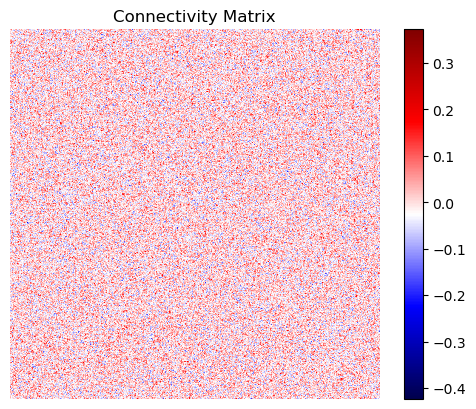

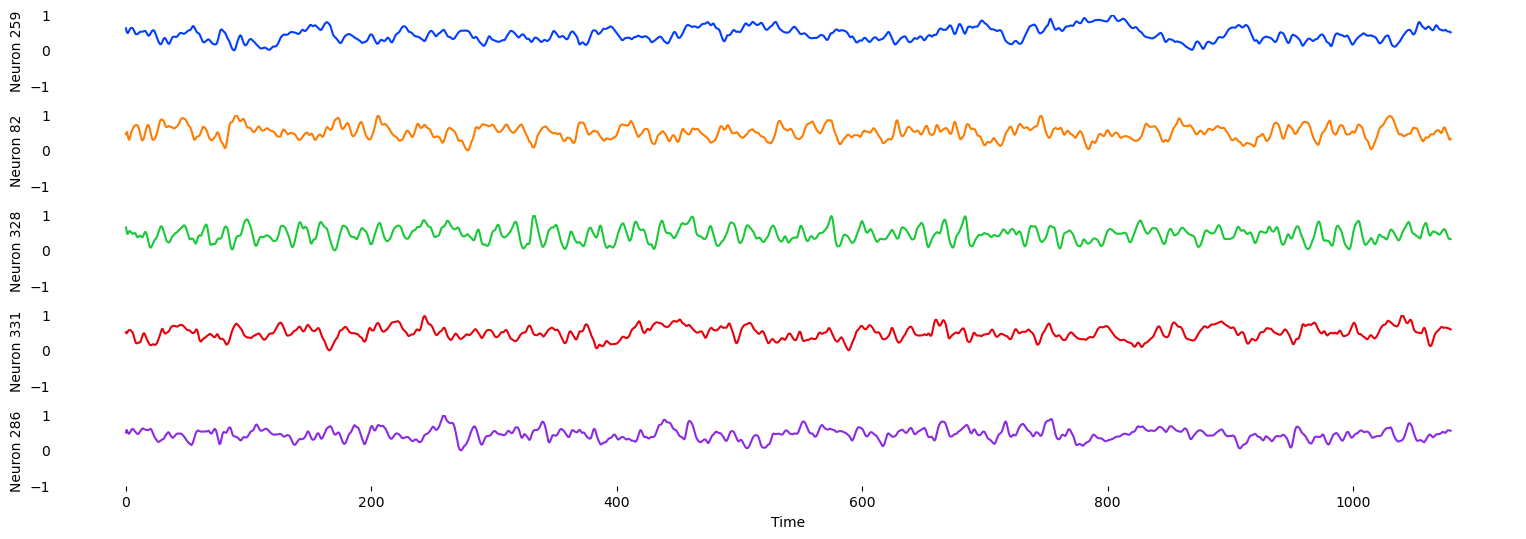

In [4]:
# Number of neurons
num_neurons = 500

# Connectivity matrix
g = 2

# Time parameters
tau = 1
dt = 0.1
time_steps = 10797

data = SyntheticNeuralData(num_neurons, g, tau, dt, time_steps)
data.plotMAtrixJ()

scaler = MinMaxScaler()
scaler.fit(data.h)
h = scaler.transform(data.h)

plot_signals(torch.from_numpy(h), torch.from_numpy(data.time), 5)
#data.saveData()

The richness of the simulated neural activity relies not just on the *g* parameter, but on the number of neurons we are considering too.
I'm interested to train a neural network using this dynamics, to learn the best *J* values.

In [5]:
# Real data
config = OmegaConf.load("/home/lrvnc/projects/worm-graph/conf/dataset.yaml")
print("\nconfig:\n\t", OmegaConf.to_yaml(config), end="\n\n")
dataset = get_dataset(config)


config:
	 dataset:
  name:
  - Kato2015


Chosen dataset(s): ['Kato2015']
Num. worms: 12



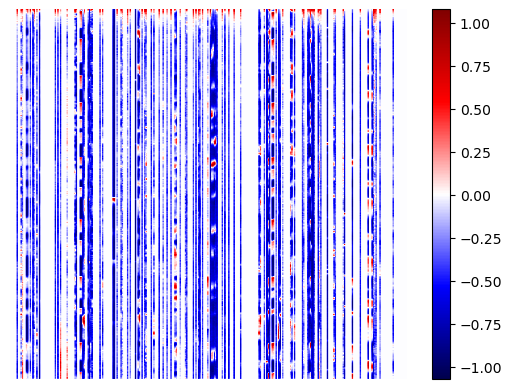

In [6]:
oneWorm = dataset['worm0']
simplePlotMatrix(oneWorm['smooth_calcium_data'])

To train with this data, I want to do something similar to what they do to train transformers. I split the neural data into chunck of data, with a fixed length. Each chunk will have *len_chunk* examples to train.

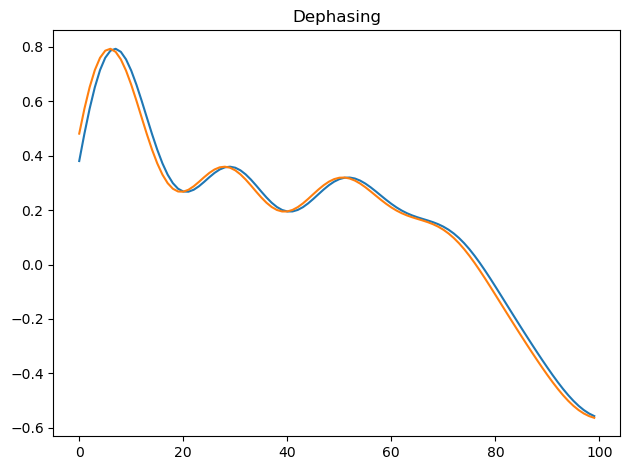

In [7]:
x = oneWorm['smooth_calcium_data'] # (time_steps, num_neurons)
x = x[:-1, :] # (time_steps - 1, num_neurons)
y = x[1:, :] # (time_steps - 1, num_neurons)
plt.plot(x[:100, 50])
plt.plot(y[:100, 50])
plt.title('Dephasing')
plt.tight_layout()
plt.show()

In [8]:
torch.manual_seed(1337)

data = oneWorm['smooth_calcium_data']

# Let's split the data into train and val sets
n = int(0.9*len(data))
train_data = data[:n, :]
val_data = data[n:, :]
print('Shape of train_data: {}'.format(train_data.shape))
print('Shape of test_data: {}'.format(val_data.shape))

Shape of train_data: torch.Size([6477, 302])
Shape of test_data: torch.Size([720, 302])


In [9]:
# We define a function to generate a batch of randomly picked blocks from our text
def get_batch(data, block_size, batch_size, dephasing=1):
    # Generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data)-block_size, (batch_size,)) # random start indices for the examples
    x = torch.stack([data[i:i+block_size, :] for i in ix]) # (batch_size, block_size)
    y = torch.stack([data[i+dephasing:i+dephasing+block_size, :] for i in ix]) # targets (the same as inputs, but shifted by dephasing ahead)
    return x.to(device), y.to(device)

xb, yb = get_batch(train_data, block_size=8, batch_size=4)
print('Shape of xb: {} and yb: {}'.format(xb.shape, yb.shape))

Shape of xb: torch.Size([4, 8, 302]) and yb: torch.Size([4, 8, 302])


In [10]:
# Preliminar tests
num_neurons = train_data.shape[1]
block_size = 2**9
batch_size = 2**5
loops = 100

xb, yb = get_batch(train_data, block_size=block_size, batch_size=batch_size)

model = WeirdCTRNN(block_size=block_size, num_neurons=num_neurons, loops=loops, dt=0.1, tau=1.0, g=1.5).to(device)
out, loss = model(xb.to(device), yb.to(device))
loss.item(), out.shape

(0.09914661943912506, torch.Size([32, 512, 302]))

In [11]:
eval_iters = 100
max_iters = 500
eval_interval = 10

num_neurons = train_data.shape[1]
block_size = 2**9
batch_size = 2**4
loops = 1

info = {'train': [],
        'val': []}

model = WeirdCTRNN(block_size=block_size, num_neurons=num_neurons, loops=loops, dt=0.1, tau=1.0, g=1.5).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Evaluation function
@torch.no_grad()
def estimate_loss():
    # Evaluate the model on the validation set
    # Performs batch average over the validation set
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            if split == 'train':
                X, Y = get_batch(train_data, block_size=block_size, batch_size=batch_size)
            else:
                X, Y = get_batch(val_data, block_size=block_size, batch_size=batch_size)
            out, loss = model(X, Y)
            losses[k] = loss.item()
        info[split].append(losses.mean())
    model.train()

# Training loop
for step in tqdm(range(max_iters)):

    # Every once in a while evaluate the loss on train and val sets
    if step % eval_interval == 0:
        estimate_loss()
        #print(f"step {step}: train loss {info['train']:.8f}, val loss {info['val']:.8f}")
    
    # Get a batch of data
    xb, yb = get_batch(train_data, block_size=block_size, batch_size=batch_size)
    # Evaluate the loss
    out, loss = model(xb.to(device), yb.to(device))
    # Reset the gradients
    optimizer.zero_grad(set_to_none=True)
    # Backpropagate the loss
    loss.backward()
    # Update the parameters
    optimizer.step()

100%|██████████| 500/500 [00:47<00:00, 10.57it/s]


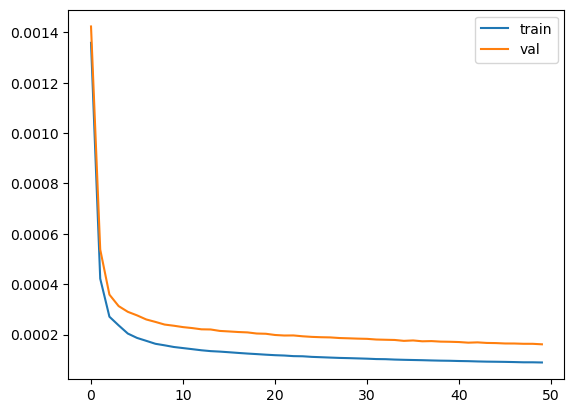

In [12]:
plt.plot(info['train'], label='train')
plt.plot(info['val'], label='val')
plt.legend()
plt.show()

In [13]:
x0 = train_data[0, :].to(device) # (num_neurons,)
x0.unsqueeze_(0) # (1, num_neurons)

sim = model.generate(x0, 1000)
sim = torch.from_numpy(sim.cpu().detach().numpy())

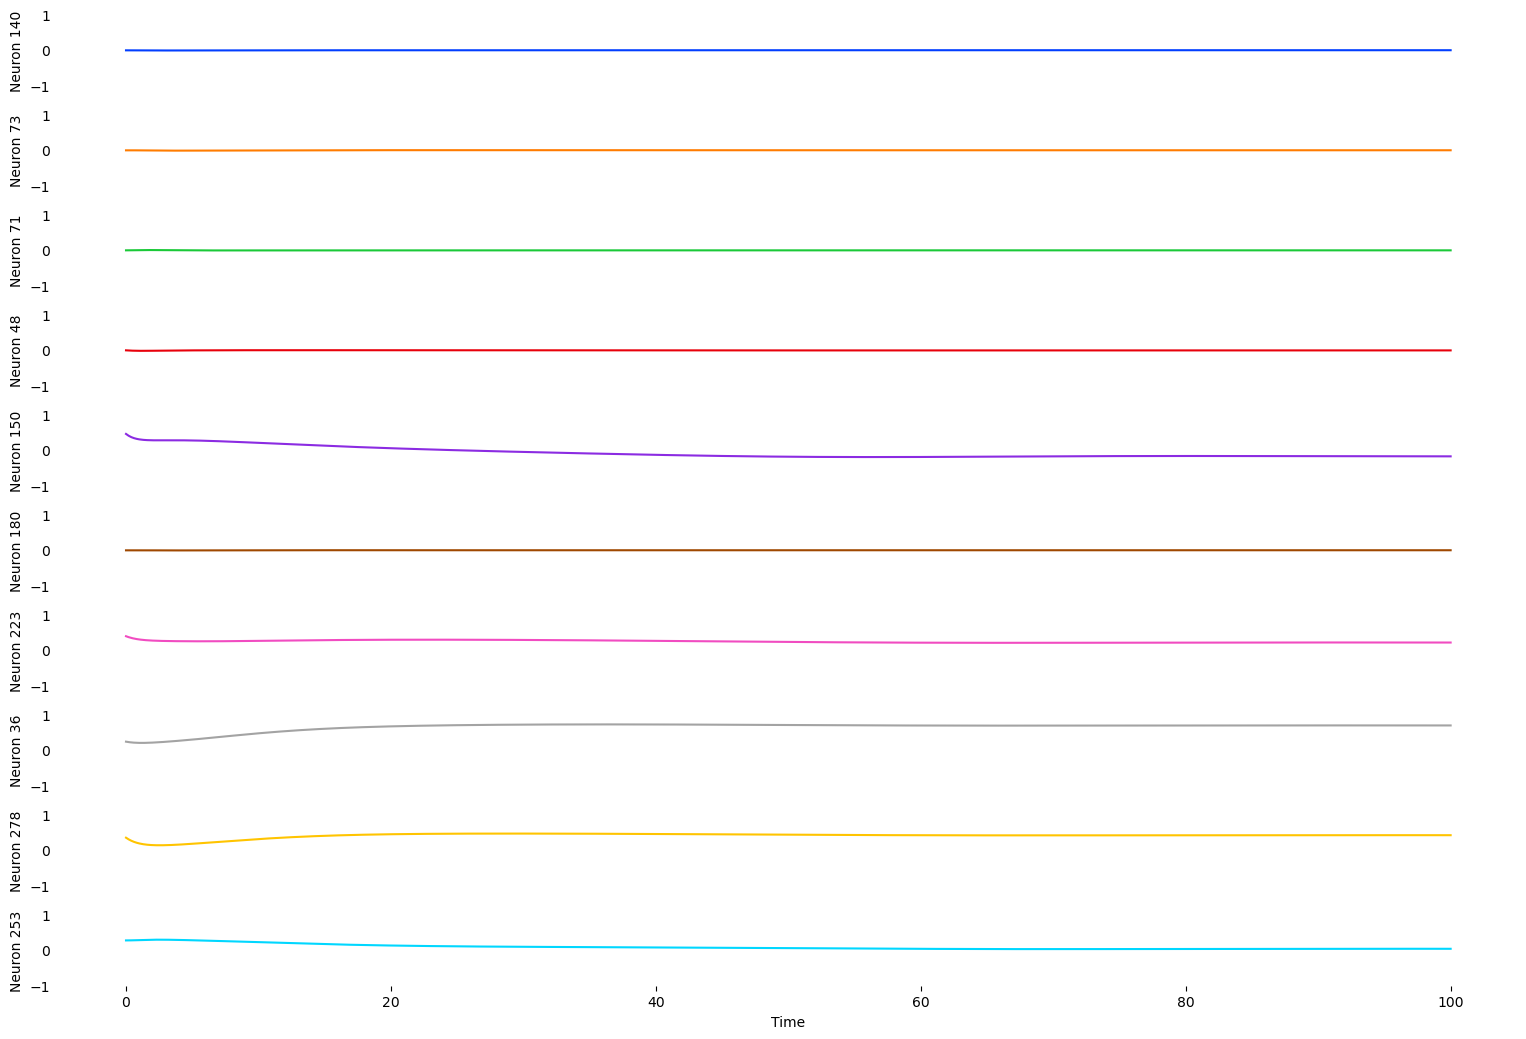

In [14]:
plot_signals(sim, oneWorm['time_in_seconds'][:1001], 10)